In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
import string
import nltk
from nltk.corpus import wordnet, cmudict, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
#nltk.download('punkt_tab')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger_eng')

from textblob import TextBlob
from gensim.models import LsiModel
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from collections import Counter
import textstat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier

from scipy.sparse import hstack

In [2]:
data = pd.read_csv("../../data/10k_sampled_dataset.csv", encoding="utf-8")
data.head()

,text,source,prompt_id,text_length,word_count
0,"In 1466, perhaps 40,000 people died of the pla...",Flan-T5-XXL,0,336,63
1,Amazon's yet-unnamed Lord of the Rings origina...,GLM-130B,0,2251,393
2,@Holt \n***Hi. I've just rewritten the essay....,Human,0,1994,337
3,Pleasantly surprised! Had a few options for ve...,GLM-130B,0,4182,797
4,Shakespeare’s Othello: A Tragic Hero Research ...,Human,0,12845,2143


# Data Exploration

In [3]:
df = data.copy()
df["source"] = df["source"].apply(lambda x: "AI" if x != "Human" else x)
df.drop(columns="prompt_id", inplace=True)
df.head(3)

,text,source,text_length,word_count
0,"In 1466, perhaps 40,000 people died of the pla...",AI,336,63
1,Amazon's yet-unnamed Lord of the Rings origina...,AI,2251,393
2,@Holt \n***Hi. I've just rewritten the essay....,Human,1994,337


In [4]:
df["source"].value_counts(normalize=True)

source
Human    0.5577
AI       0.4423
Name: proportion, dtype: float64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         10000 non-null  object
 1   source       10000 non-null  object
 2   text_length  10000 non-null  int64 
 3   word_count   10000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 312.6+ KB


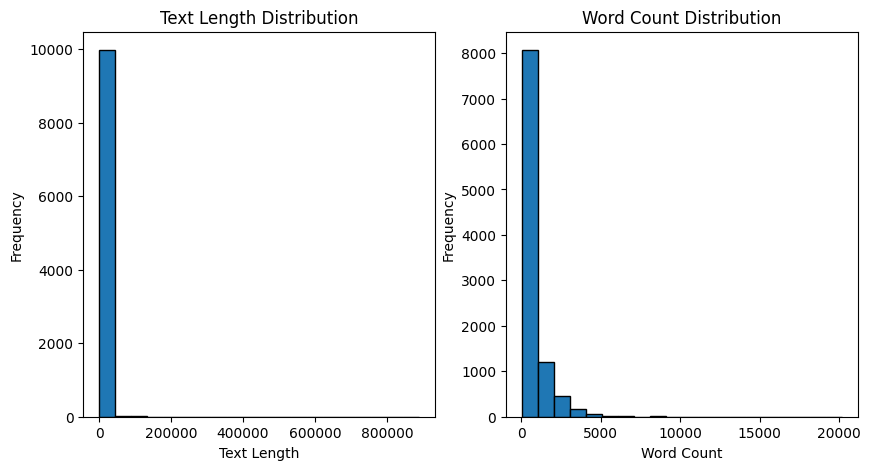

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].hist(df["text_length"], bins=20, edgecolor="black")
axes[0].set_title("Text Length Distribution")
axes[0].set_xlabel("Text Length")
axes[0].set_ylabel("Frequency")

axes[1].hist(df["word_count"], bins=20, edgecolor="black")
axes[1].set_title("Word Count Distribution")
axes[1].set_xlabel("Word Count")
axes[1].set_ylabel("Frequency")

plt.show()


In [7]:
# Check if text column contains numbers and special characters

df["contains_numbers"] = df["text"].str.contains(r"\d", regex=True)
df["contains_special_chars"] = df["text"].str.contains(r"[^\w\s]", regex=True)

df.head()

,text,source,text_length,word_count,contains_numbers,contains_special_chars
0,"In 1466, perhaps 40,000 people died of the pla...",AI,336,63,True,True
1,Amazon's yet-unnamed Lord of the Rings origina...,AI,2251,393,True,True
2,@Holt \n***Hi. I've just rewritten the essay....,Human,1994,337,True,True
3,Pleasantly surprised! Had a few options for ve...,AI,4182,797,True,True
4,Shakespeare’s Othello: A Tragic Hero Research ...,Human,12845,2143,True,True


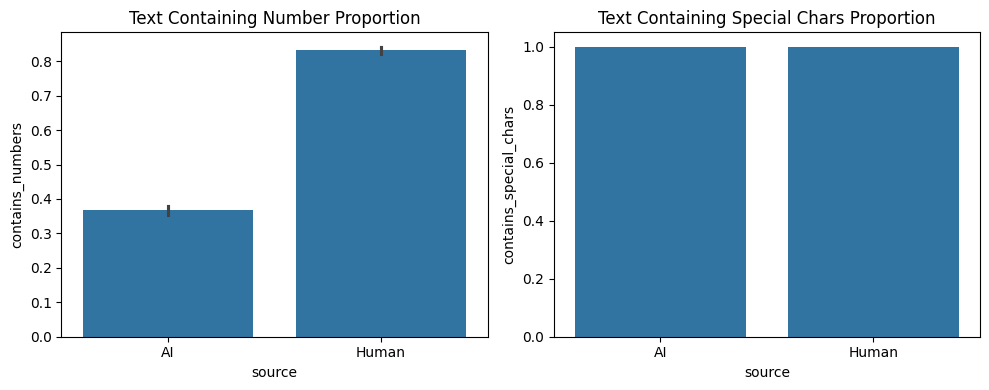

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(x=df["source"], y=df["contains_numbers"], ax=axes[0])
axes[0].set_title("Text Containing Number Proportion")

sns.barplot(x=df["source"], y=df["contains_special_chars"], ax=axes[1])
axes[1].set_title("Text Containing Special Chars Proportion")

plt.tight_layout();

In [9]:
df["contains_numbers"].value_counts()

contains_numbers
True     6262
False    3738
Name: count, dtype: int64

In [10]:
df["contains_special_chars"].value_counts()

contains_special_chars
True     9999
False       1
Name: count, dtype: int64

# Data Cleaning

In [11]:
def text_cleaning(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers (optional)
    text = re.sub(r'\d+', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = ' '.join(text.split())
    return text

In [12]:
# Testing text cleaning function

text_cleaning(df["text"].iloc[4])

'shakespeare’s othello a tragic hero research paper although his name is associated with athens aristotle was a native of thrace where he was born in bc his father nicomathus who died while aristotle was young was physician at the court of macedon and the son’s fortunes were always tied to those of the macedonian rulers frost in when he was about seventeen aristotle came to athens to study with plato of the academy he stayed there for twenty years unfortunately little is known about the personal relationship between the two greatest thinkers of their time the one bringing to a close a long productive career the other in his formative years it is suggested that aristotle had broken off with plato and was ready to leave the academy before the latter’s death in frost “as a pupil of plato aristotle and his master stand among the world’s very greatest of philosophers” frost in philip of macedon attacked stagira nearly forty his master dead and his ancestral home destroyed aristotle left ath

In [13]:
df_clean = df.drop(columns=["contains_numbers", "contains_special_chars"])
df_clean.head()

,text,source,text_length,word_count
0,"In 1466, perhaps 40,000 people died of the pla...",AI,336,63
1,Amazon's yet-unnamed Lord of the Rings origina...,AI,2251,393
2,@Holt \n***Hi. I've just rewritten the essay....,Human,1994,337
3,Pleasantly surprised! Had a few options for ve...,AI,4182,797
4,Shakespeare’s Othello: A Tragic Hero Research ...,Human,12845,2143


In [14]:
df_clean["clean_text"] = df_clean["text"].apply(text_cleaning)

# Add new columns to label, calculate char and words in the cleaned_text
df_clean["label"] = df_clean["source"].apply(lambda x: 1 if x == "AI" else 0) #AI=1, Human=0

In [15]:
df_clean = df_clean[["clean_text", "label"]]
df_clean.head(2)

,clean_text,label
0,in perhaps people died of the plague in paris ...,1
1,amazons yetunnamed lord of the rings original ...,1


# Preprocessing

In [16]:
# Text vectorization using TF-IDF

X_text = df_clean["clean_text"]

vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')

X_vec = vectorizer.fit_transform(X_text)

X_vec.shape

(10000, 10000)

# Model Training & Evaluation

In [17]:
# Exclude warnings from printing out

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [18]:
# Train, test, split
X = X_vec
y = df_clean["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split for validation data

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (7200, 10000) (7200,)
Validation set shape: (800, 10000) (800,)
Test set shape: (2000, 10000) (2000,)


In [19]:
# Evaluate model

def evaluate_model(model_name, y_true, y_pred, y_prob):
    loss = log_loss(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    print(f"{model_name}")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"ROC-AUC: {auc:.4f}")

In [20]:
# Confusion Matrix

def conf_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human (0)', 'AI (1)'], yticklabels=['Human (0)', 'AI (1)'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} - Confusion Matrix");

### GRADIENT BOOSTING

In [21]:
epochs = 200

grad_boost = GradientBoostingClassifier(
    max_depth=3,
    n_estimators=epochs,
    learning_rate=0.1)

grad_boost.fit(X_train, y_train)

train_acc_history = []
val_acc_history = []

best_val_acc = 0.0
best_epoch = 0

train_stages = grad_boost.staged_predict(X_train)
val_stages = grad_boost.staged_predict(X_val)

for epoch, (train_pred, val_pred) in enumerate(zip(train_stages, val_stages), start=1):
    # Calculate accuracies
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)

    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    # Track the best validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch

    print(f"Epoch {epoch}/{epochs} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

print(f"\nBest Validation Accuracy: {best_val_acc:.4f} at epoch {best_epoch}")

Epoch 1/200 - Train Acc: 0.5583, Val Acc: 0.5513
Epoch 2/200 - Train Acc: 0.5685, Val Acc: 0.5575
Epoch 3/200 - Train Acc: 0.8224, Val Acc: 0.8263
Epoch 4/200 - Train Acc: 0.8292, Val Acc: 0.8250
Epoch 5/200 - Train Acc: 0.8283, Val Acc: 0.8275
Epoch 6/200 - Train Acc: 0.8311, Val Acc: 0.8287
Epoch 7/200 - Train Acc: 0.8297, Val Acc: 0.8313
Epoch 8/200 - Train Acc: 0.8322, Val Acc: 0.8313
Epoch 9/200 - Train Acc: 0.8379, Val Acc: 0.8350
Epoch 10/200 - Train Acc: 0.8394, Val Acc: 0.8375
Epoch 11/200 - Train Acc: 0.8411, Val Acc: 0.8462
Epoch 12/200 - Train Acc: 0.8419, Val Acc: 0.8400
Epoch 13/200 - Train Acc: 0.8489, Val Acc: 0.8588
Epoch 14/200 - Train Acc: 0.8431, Val Acc: 0.8488
Epoch 15/200 - Train Acc: 0.8510, Val Acc: 0.8662
Epoch 16/200 - Train Acc: 0.8515, Val Acc: 0.8662
Epoch 17/200 - Train Acc: 0.8531, Val Acc: 0.8638
Epoch 18/200 - Train Acc: 0.8556, Val Acc: 0.8662
Epoch 19/200 - Train Acc: 0.8576, Val Acc: 0.8638
Epoch 20/200 - Train Acc: 0.8588, Val Acc: 0.8675
Epoch 21/

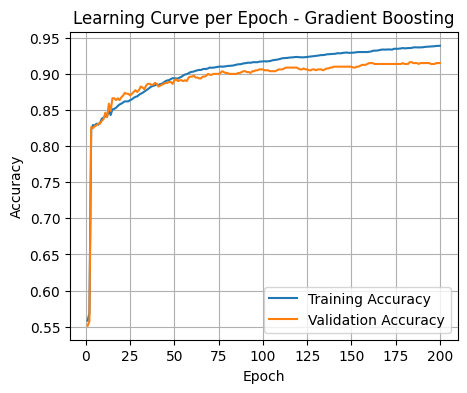

In [22]:
plt.figure(figsize=(5, 4))
plt.plot(range(1, epochs+1), train_acc_history, label="Training Accuracy")
plt.plot(range(1, epochs+1), val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Learning Curve per Epoch - Gradient Boosting")
plt.legend()
plt.grid(True);

In [23]:
# Gradient Boosting evaluation

grad_y_val_pred = grad_boost.predict(X_val)
grad_y_val_prob = grad_boost.predict_proba(X_val)[:, 1]

grad_loss = log_loss(y_val, grad_y_val_prob)
grad_acc = accuracy_score(y_val, grad_y_val_pred)
grad_prec = precision_score(y_val, grad_y_val_pred)
grad_rec = recall_score(y_val, grad_y_val_pred)
grad_auc = roc_auc_score(y_val, grad_y_val_prob)

print("\nValidation Set Evaluation - Gradient Boosting")
print(f"Loss: {grad_loss:.4f}")
print(f"Accuracy: {grad_acc:.4f}")
print(f"Precision: {grad_prec:.4f}")
print(f"Recall: {grad_rec:.4f}")
print(f"ROC-AUC: {grad_auc:.4f}")


Validation Set Evaluation - Gradient Boosting
Loss: 0.2440
Accuracy: 0.9150
Precision: 0.8740
Recall: 0.9471
ROC-AUC: 0.9659


In [24]:
# Saving score result to Halim_model_results.ipynb

save_result = [{
    "Model": "Gradient Boost (Viviek's cleaning) No Feature",
    "Loss": f"{grad_loss:.4f}",
    "Accuracy": f"{grad_acc:.4f}"
    }]

df_result = pd.DataFrame(save_result)
csv_file = "10k_model_results.csv"
df_result.to_csv(csv_file, mode="a", index=False, header=not os.path.exists(csv_file))

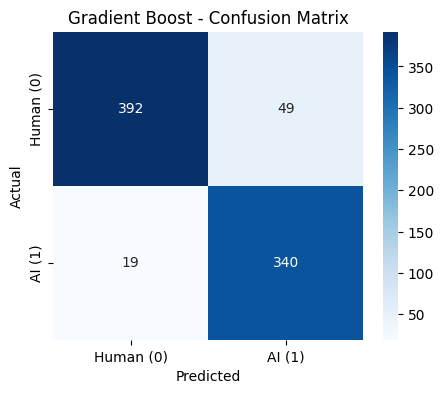

In [25]:
conf_matrix("Gradient Boost", y_val, grad_y_val_pred)

# Prediction

In [26]:
def preprocess_input(sentence, vectorizer):
    """Preprocess the raw input text"""

    # Ensure input is a string
    if not isinstance(sentence, str):
        raise ValueError("Input sentence must be a string")

    cleaned_text = text_cleaning(sentence) # Clean the text
    text_vectorized = vectorizer.transform([cleaned_text]) # Vectorize clean text

    return text_vectorized

In [27]:
def predict_text(model, sentence, vectorizer):
    preproc_input = preprocess_input(sentence, vectorizer)
    prediction_prob = model.predict_proba(preproc_input)[:, 1][0] # Extracts probability of AI clas
    prediction = "AI" if prediction_prob > 0.5 else "Human"
    return prediction, round(prediction_prob, 2)

In [28]:
df.tail()

,text,source,text_length,word_count,contains_numbers,contains_special_chars
9995,The Meaning of Civilization According to Willi...,Human,11346,1793,True,True
9996,Alicia was outside watering flowers. Alicia ac...,AI,191,34,False,True
9997,Sandy was decided to take a hike in the mounta...,AI,181,35,False,True
9998,Tommy wanted to buy a new computer. After some...,AI,478,87,True,True
9999,We investigate the problem of cost-optimal pla...,AI,4299,661,True,True


In [29]:
model = grad_boost
sentence = df["text"][995]

prediction, probability = predict_text(model, sentence, vectorizer)

print(f"{sentence}")
print(f"Prediction: {prediction} ({probability * 100:.1f}%)")
print(f"Actual: {df['source'][995]}")

Justice in the Old and New Testament Essay

The Old and New Testaments are significantly different in many aspects, likely as a consequence of the time difference between their time of writing. Both consider it essential, but they assign it, and the qualities associated with it, different roles. The Old Testament gives righteousness a clear definition and makes it a critical attribute of God, ruler, and individual. By comparison, the New Testament depicts it as coming from God and only possible through following His will. As such, it is prudent to compare the two definitions in detail to understand the overt and underlying differences between the two halves of the Christian canon better.

Justice in the Old Testament should be considered in terms of the meaning attributed to the term there rather than its current definition. Haacker claims that “it is about restoration, redistribution, and providing the right. […] The one who is stronger gives; the weaker receives.” Yahweh is supposed 

In [30]:
gb_predict = grad_boost.predict(X_test)

print(classification_report(y_test, gb_predict))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1116
           1       0.85      0.94      0.89       884

    accuracy                           0.90      2000
   macro avg       0.90      0.91      0.90      2000
weighted avg       0.91      0.90      0.90      2000

